<a href="https://colab.research.google.com/github/rishabhvenkat/Lempel-Ziv-Algo-for-DOC/blob/main/LZA_DOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install mne


In [16]:
import mne

In [17]:
import os

# List files in the current directory
print(os.listdir())


['.config', 'VegetativeState_27.fdt', 'VegetativeState_27.set', 'sample_data']


In [18]:
!pip install pymatreader


In [19]:
import mne

# Load the .set file
raw = mne.io.read_raw_eeglab('VegetativeState_27.set', preload=True)

# Basic info about the dataset
print(raw.info)



Reading /content/VegetativeState_27.fdt
Reading 0 ... 22133759  =      0.000 ... 86459.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: C3:REF, C4:REF, Fz:REF, Cz:REF, Pz:REF
 chs: 5 EEG
 custom_ref_applied: False
 dig: 5 items (5 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 256.0 Hz
>


<ipython-input-19-340e2a548988>:4: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab('VegetativeState_27.set', preload=True)


In [20]:
# List all channel names
print("Channel names:", raw.ch_names)

# Check the type of each channel
print("Channel types:", raw.get_channel_types())


Channel names: ['C3:REF', 'C4:REF', 'Fz:REF', 'Cz:REF', 'Pz:REF']
Channel types: ['eeg', 'eeg', 'eeg', 'eeg', 'eeg']


In [21]:
# Get data dimensions (channels, time points)
data, times = raw.get_data(return_times=True)
print("Data shape (channels x time points):", data.shape)
print("Duration of recording (seconds):", times[-1])


Data shape (channels x time points): (5, 22133760)
Duration of recording (seconds): 86459.99609375


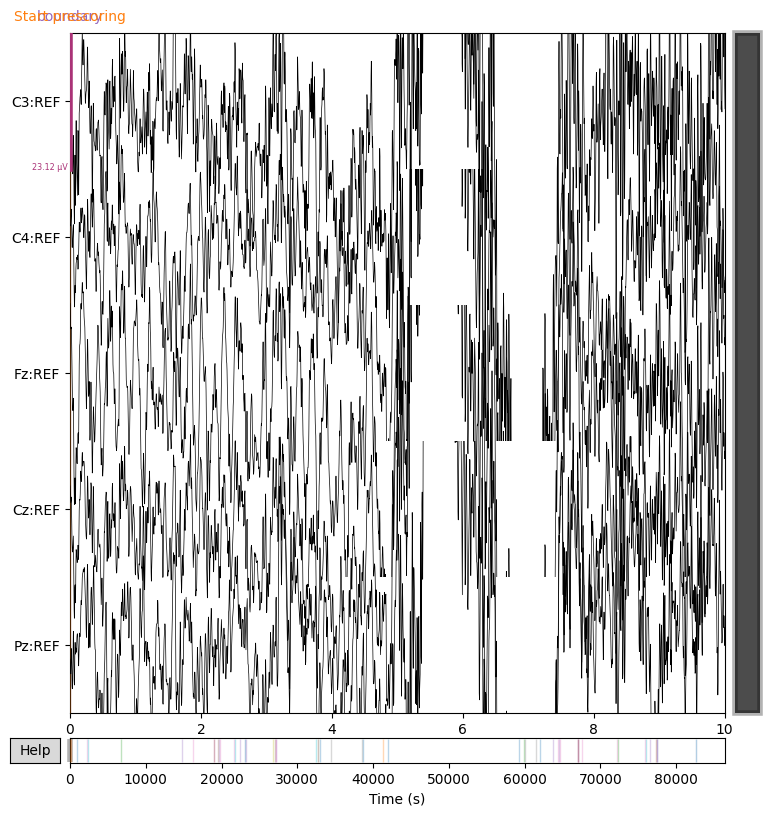

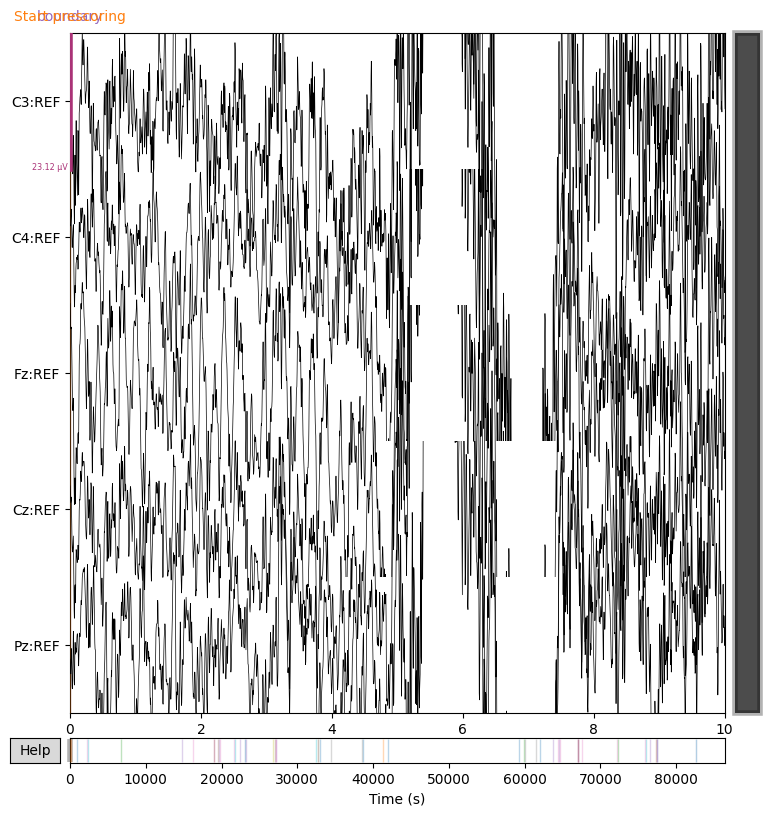

In [22]:
# Plot a snippet of raw EEG data
raw.plot(n_channels=5, scalings='auto', duration=10, title="EEG Data")


In [23]:
!pip install numpy scipy


In [24]:
import numpy as np
from scipy.signal import butter, filtfilt
import mne

# Load the .set file
raw = mne.io.read_raw_eeglab('VegetativeState_27.set', preload=True)

# Define constants
fs = int(raw.info['sfreq'])  # Sampling frequency (Hz) from dataset metadata
lowcut, highcut = 0.5, 30   # Bandpass filter limits (Hz)

# Bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Extract EEG data
eeg_data = raw.get_data()  # Shape: (channels, time points)

# Apply bandpass filter to all channels
filtered_data = np.array([bandpass_filter(channel, lowcut, highcut, fs) for channel in eeg_data])

# Print the shape of filtered data
print("Filtered data shape:", filtered_data.shape)


Reading /content/VegetativeState_27.fdt
Reading 0 ... 22133759  =      0.000 ... 86459.996 secs...


<ipython-input-24-266816db2254>:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab('VegetativeState_27.set', preload=True)


Filtered data shape: (5, 22133760)


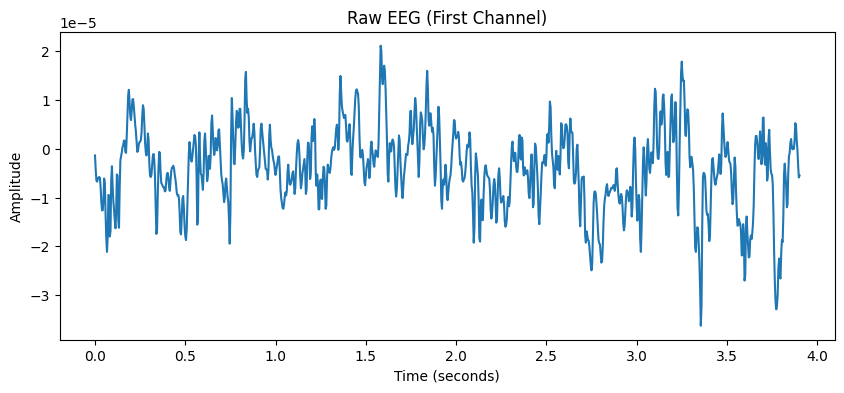

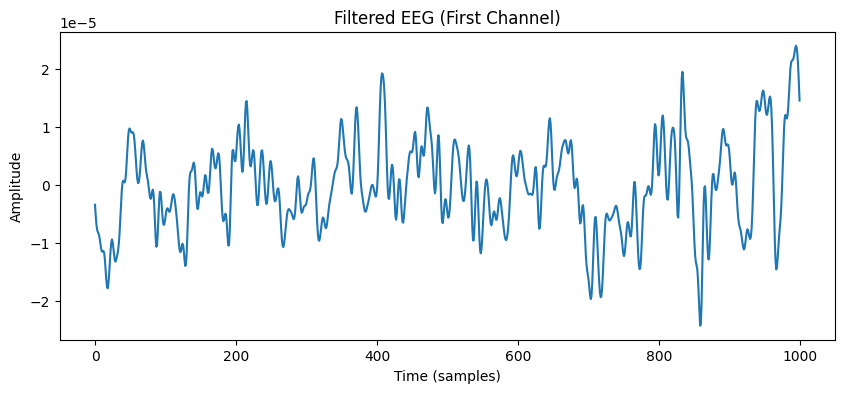

In [25]:
import matplotlib.pyplot as plt

# Plot raw EEG (first channel)
plt.figure(figsize=(10, 4))
plt.plot(raw.times[:1000], raw.get_data(picks=[0])[0, :1000])  # First 1000 samples of the first channel
plt.title("Raw EEG (First Channel)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

# Plot filtered EEG (first channel)
plt.figure(figsize=(10, 4))
plt.plot(filtered_data[0][:1000])  # First 1000 samples of the filtered first channel
plt.title("Filtered EEG (First Channel)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()


In [26]:
# Function to calculate the Lempel-Ziv Complexity
def lempel_ziv_complexity(binary_sequence):
    s = ''.join(map(str, binary_sequence))
    complexity = 1
    i, k, l = 0, 1, 1
    while True:
        if s[i + k - 1] == s[l + k - 1]:
            k += 1
            if l + k > len(s):
                complexity += 1
                break
        else:
            if k == 1:
                complexity += 1
                l += 1
                if l == len(s):
                    break
            else:
                i += 1
                k = 1
                if i == l:
                    l += 1
                    if l == len(s):
                        break
    return complexity

# Applying LZC to all channels with dynamic thresholding
lzc_values = []
threshold_factor = 1.2  # Adjust this factor to fit your data

for channel in filtered_data:
    # Convert to binary sequence using dynamic thresholding
    threshold = np.mean(channel)
    binary_sequence = (channel > threshold).astype(int)

    # Compute LZC for each window
    window_size = 256 * 10  # 10-second window size
    step_size = 256 * 5     # 5-second step size

    segment_lzc_values = []
    for i in range(0, len(binary_sequence) - window_size, step_size):
        window = binary_sequence[i:i + window_size]
        lzc_value = lempel_ziv_complexity(window)
        segment_lzc_values.append(lzc_value)

    # Average LZC for the entire channel
    avg_lzc_value = np.mean(segment_lzc_values)
    lzc_values.append(avg_lzc_value)

    print(f"LZC for channel: {avg_lzc_value}")


LZC for channel: 2528.1217466743783
LZC for channel: 2521.430884904569
LZC for channel: 2525.968016194332
LZC for channel: 2527.576923076923
LZC for channel: 2524.0441873915556


In [27]:
# Use dynamic thresholding based on LZC values
lzc_mean = np.mean(lzc_values)
lzc_std = np.std(lzc_values)

# Define a threshold: For example, anything above mean + 1 * std could be considered wake
wake_threshold = lzc_mean + threshold_factor * lzc_std

# Count wake segments: Count segments where LZC value is above threshold
wake_segments = sum(lzc_value > wake_threshold for lzc_value in lzc_values)

print(f"Number of wake segments: {wake_segments}")



Number of wake segments: 0


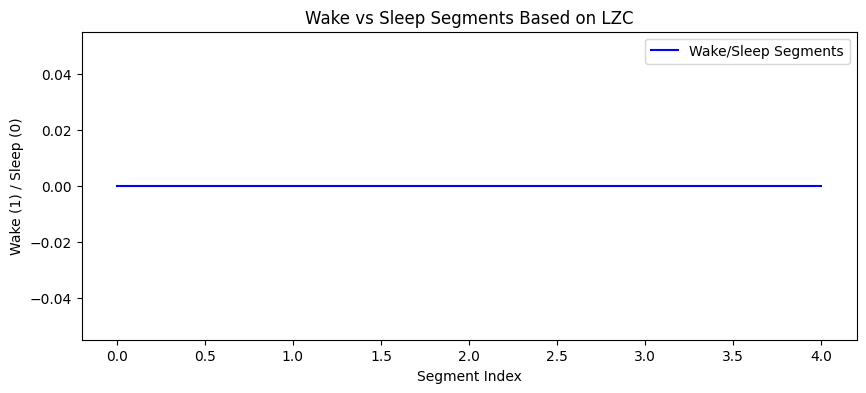

In [28]:
# Create a list of labels: 1 for wake, 0 for sleep
wake_labels = [1 if lzc_value > wake_threshold else 0 for lzc_value in lzc_values]

# Plot the wake/sleep segments
plt.figure(figsize=(10, 4))
plt.plot(wake_labels, label="Wake/Sleep Segments", color="blue")
plt.title("Wake vs Sleep Segments Based on LZC")
plt.xlabel("Segment Index")
plt.ylabel("Wake (1) / Sleep (0)")
plt.legend()
plt.show()

